In [167]:
import pandas as pd
import numpy as np 
import re
import statistics
import json
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import numpy as np
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/josephchung/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [115]:
tiktok = pd.read_csv('/Users/josephchung/PycharmProjects/hyp-ecomm/tiktok_data_analysis/output_final.csv')

In [116]:
def creators_of_interest_filtered_df(df, creators_of_interest): 
    df_filtered = df[df['title'].isin(creators_of_interest)]
    return df_filtered

In [153]:
#creator analysis taking in the filtered dataframe with only the creators of interest
#returns creators_df and print out stats
def creators_analysis(df): 
    ##converting followers into float
    followers = df['followers'].astype('string')
    followers_array = []
    for i in range(len(followers)): 
        num = followers[i]
        if type(num) is str and 'K' in num:
            num = num.replace('K', '')
            num = np.float64(num)
            num = num * 1000
            followers_array.append(num)
        elif type(num) is str and 'M' in num: 
            num = num.replace('M', '')
            num = np.float64(num)
            num = num * 1000000
            followers_array.append(num)
        elif num is pd.NA: ##converting <NA> values to 0 
            num = 0.0
            followers_array.append(num)
        else: 
            num = np.float64(num)
            followers_array.append(num)
    df['followers'] = followers_array
    creators_df = df[['title', 'following', 'followers', 'total_videos']]
    creators_df = creators_df.rename(columns={'title':'user'})
    
    print("The average amount of followers for BYBI brand collaborators are ", creators_df['followers'].mean())
    print("The max amount of followers that an BYBI brand collaborator has is ", creators_df['followers'].max())
    print("The minimum amount of followers that an BYBI brand collaborator has is ", creators_df['followers'].min())
    
    print("The average amount of posts for BYBI brand collaborators are ", creators_df['total_videos'].mean())
    print("The max amount of posts that an BYBI brand collaborator has is ", creators_df['total_videos'].max())
    print("The minimum amount of posts that an BYBI brand collaborator has is ", creators_df['total_videos'].min())
    
    print("The average amount of people following for BYBI brand collaborators are ", creators_df['following'].mean())
    print("The max amount of people following that an BYBI brand collaborator has is ", creators_df['following'].max())
    print("The minimum amount of people following that an BYBI brand collaborator has is ", creators_df['following'].min())
    return creators_df

In [162]:
def posts_analysis(df):
    url_array= []
    account_array =[]
    likes_array = []
    comments_array = []
    caption_array = []
    columns = np.array(df.columns)
    for k in df.index: 
        for i in range(269):
            for j in tiktok.columns:
                if "videos_list/" + str(i) in j:    
                    url_array.append(df['videos_list/' + str(i)][k])
                    account_array.append(df['title'][k])
                    if "video_details/" + str(i) + "/like_count" in columns:
                        likes_array.append(df['video_details/' + str(i) + '/like_count'][k])
                    else: 
                        likes_array.append(np.nan)
                    if "video_details/" + str(i) + "/comment_count" in df.columns:
                        comments_array.append(df['video_details/' + str(i) + '/comment_count'][k])
                    else: 
                        comments_array.append(np.nan)
                    if "video_details/" + str(i) + "/name" in df.columns:
                        caption_array.append(df['video_details/' + str(i) + '/name'][k])
                    else: 
                        caption_array.append(np.nan)
    posts_df = pd.DataFrame(account_array)
    posts_df['videos'] = url_array
    posts_df['likes'] = likes_array
    posts_df['comments'] = comments_array
    posts_df['caption'] = caption_array
    posts_df = posts_df.rename(columns = {0 : 'user'})
    ##converting likes into float
    likes = posts_df['likes'].astype('string')
    likes_count_array = []
    for i in range(len(likes)): 
        num = likes[i]
        if type(num) is str and 'K' in num:
            num = num.replace('K', '')
            num = np.float64(num)
            num = num * 1000
            likes_count_array.append(num)
        elif type(num) is str and 'M' in num: 
            num = num.replace('M', '')
            num = np.float64(num)
            num = num * 1000000
            likes_count_array.append(num)
        elif num is pd.NA: ##converting <NA> values to 0 
            num = 0.0
            likes_count_array.append(num)
        else: 
            num = np.float64(num)
            likes_count_array.append(num)
    posts_df['likes'] = likes_count_array
    
        ##converting comments into float
    comments = posts_df['comments'].astype('string')
    comments_count_array = []
    for i in range(len(likes)): 
        num = comments[i]
        if type(num) is str and 'K' in num:
            num = num.replace('K', '')
            num = np.float64(num)
            num = num * 1000
            comments_count_array.append(num)
        elif type(num) is str and 'M' in num: 
            num = num.replace('M', '')
            num = np.float64(num)
            num = num * 1000000
            comments_count_array.append(num)
        elif num is pd.NA: ##converting <NA> values to 0 
            num = 0.0
            comments_count_array.append(num)
        else: 
            num = np.float64(num)
            comments_count_array.append(num)
    posts_df['comments'] = comments_count_array
    return posts_df

In [224]:
def posts_stats_df(df): 
    post_stats = df.groupby('user').agg({'likes':['mean','max','min'], 'comments': ['mean','max', 'min']})
    
    def calculate_sentiment(text):
        # Use TextBlob or VADER to calculate sentiment
        sia = SentimentIntensityAnalyzer()
        sentiment_score = sia.polarity_scores(text)
        return sentiment_score['compound']  # Use compound score for overall sentiment

    sent_score_array = []
    for i in posts_df['caption']: 
        if type(i) == str: 
            sent_score = calculate_sentiment(i)
            sent_score_array.append(sent_score)
        else: 
            sent_score_array.append(None) 
    posts_df['sentiment'] = sent_score_array
    
    posts_df['caption'] = str(posts_df['caption'])
    
    posts_df['caption_length'] = posts_df['caption'].apply(lambda x: len(x.split()))
    avg_caption_length = posts_df.groupby('user')['caption_length'].mean().reset_index(name='avg_caption_length')
    creator_sentiment = posts_df.groupby('user')['sentiment'].mean().reset_index()

    creator_analysis = creators_df.merge(post_stats, on='user')
    creator_analysis = creator_analysis.merge(avg_caption_length, on = 'user')
    creator_analysis = creator_analysis.merge(creator_sentiment, on = 'user')
    
    creator_analysis['engagement_rate'] = ((creator_analysis[('likes', 'mean')] + creator_analysis[('comments', 'mean')]) / creator_analysis['followers'] * 100)
    return creator_analysis, posts_df

In [226]:
def eda_visualization(df, posts_df): 
    sns.set(style="whitegrid")

    # Create a bar chart for average likes per creator
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=('likes', 'mean'), y='user', data= df, ci=None)
    ax.set_xlabel('Average Likes')
    ax.set_ylabel('Username')
    plt.title('Average Likes per Content Creator')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(posts_df['caption_length'], bins=20, kde=True)
    plt.xlabel('Caption Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Caption Lengths')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=('likes', 'mean'), y=('comments', 'mean'), hue='user', s=100)
    plt.xlabel('Average Likes')
    plt.ylabel('Average Comments')
    plt.title('Correlation between Average Likes and Comments')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()
    
    # Sentiment Analysis Graph
    plt.figure(figsize=(12, 8))
    sns.barplot(x='sentiment', y='user', data= df)
    plt.xlabel('Average Sentiment')
    plt.ylabel('Instagram Username')
    plt.title('Average Sentiment per Content Creator')
    plt.show()
    
    df_sorted = df.sort_values(by='engagement_rate', ascending=False)

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.bar(df_sorted['user'], df_sorted['engagement_rate'], color='skyblue')
    plt.xlabel('Username')
    plt.ylabel('Engagement Rate (%)')
    plt.title('Engagement Rate by Instagram Creator')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [231]:
def total_analysis(creators_of_interest):
    df = creators_of_interest_filtered_df(tiktok, creators_of_interest)
    df = df.reset_index(drop = True)

    creator_df = creators_analysis(df)

    posts_df = posts_analysis(df)
    posts_stats, posts_df = posts_stats_df(posts_df)

    eda_visualization(posts_stats, posts_df)

The average amount of followers for BYBI brand collaborators are  191816.5
The max amount of followers that an BYBI brand collaborator has is  1100000.0
The minimum amount of followers that an BYBI brand collaborator has is  698.0
The average amount of posts for BYBI brand collaborators are  160.83333333333334
The max amount of posts that an BYBI brand collaborator has is  248
The minimum amount of posts that an BYBI brand collaborator has is  85
The average amount of people following for BYBI brand collaborators are  551.8333333333334
The max amount of people following that an BYBI brand collaborator has is  876.0
The minimum amount of people following that an BYBI brand collaborator has is  251.0


/var/folders/d0/lg61k8414cn85l8gxphhxyf00000gn/T/ipykernel_99522/990812382.py:25: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  creator_analysis = creators_df.merge(post_stats, on='user')
/var/folders/d0/lg61k8414cn85l8gxphhxyf00000gn/T/ipykernel_99522/510983345.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=('likes', 'mean'), y='user', data= df, ci=None)


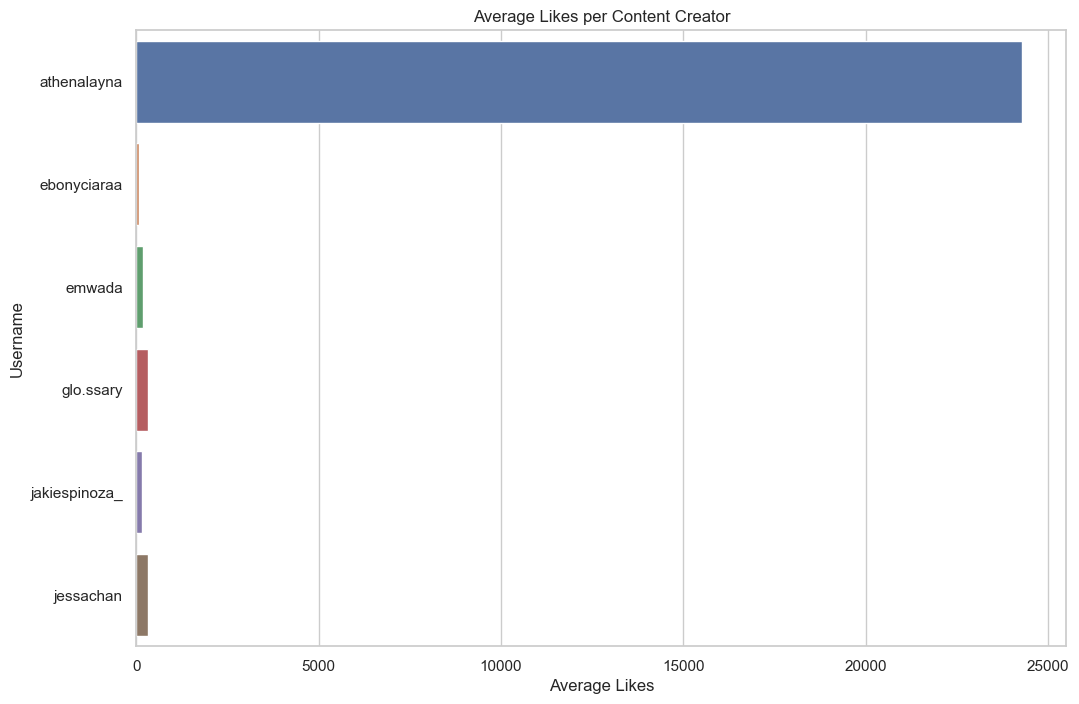

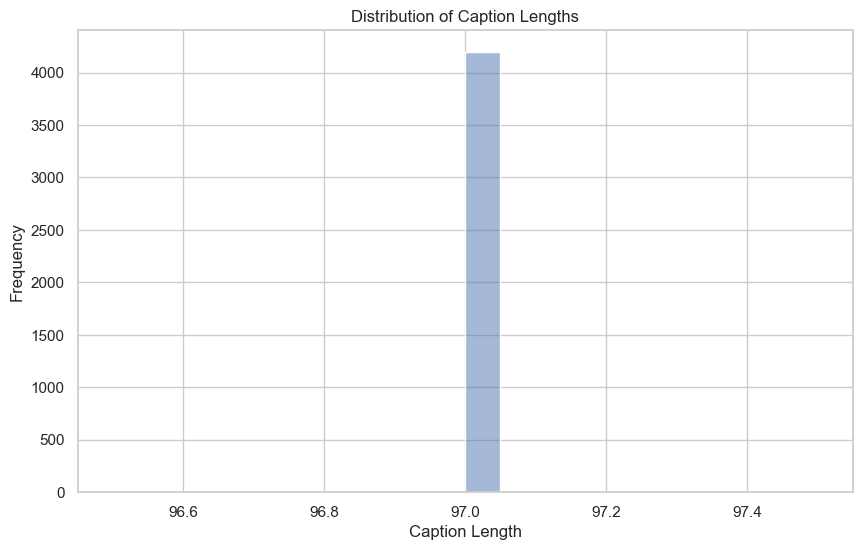

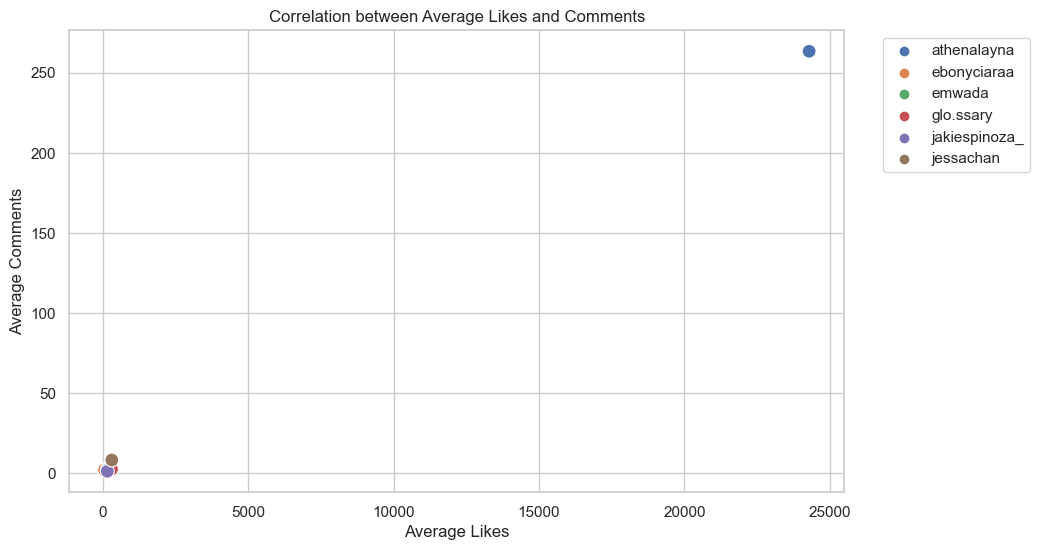

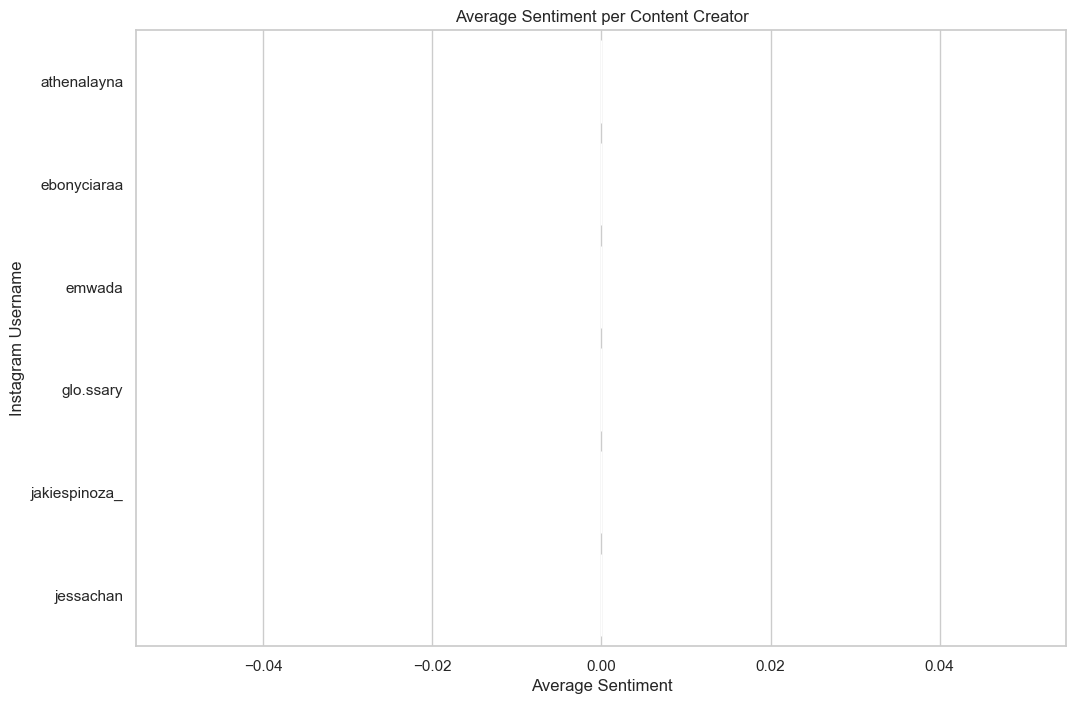

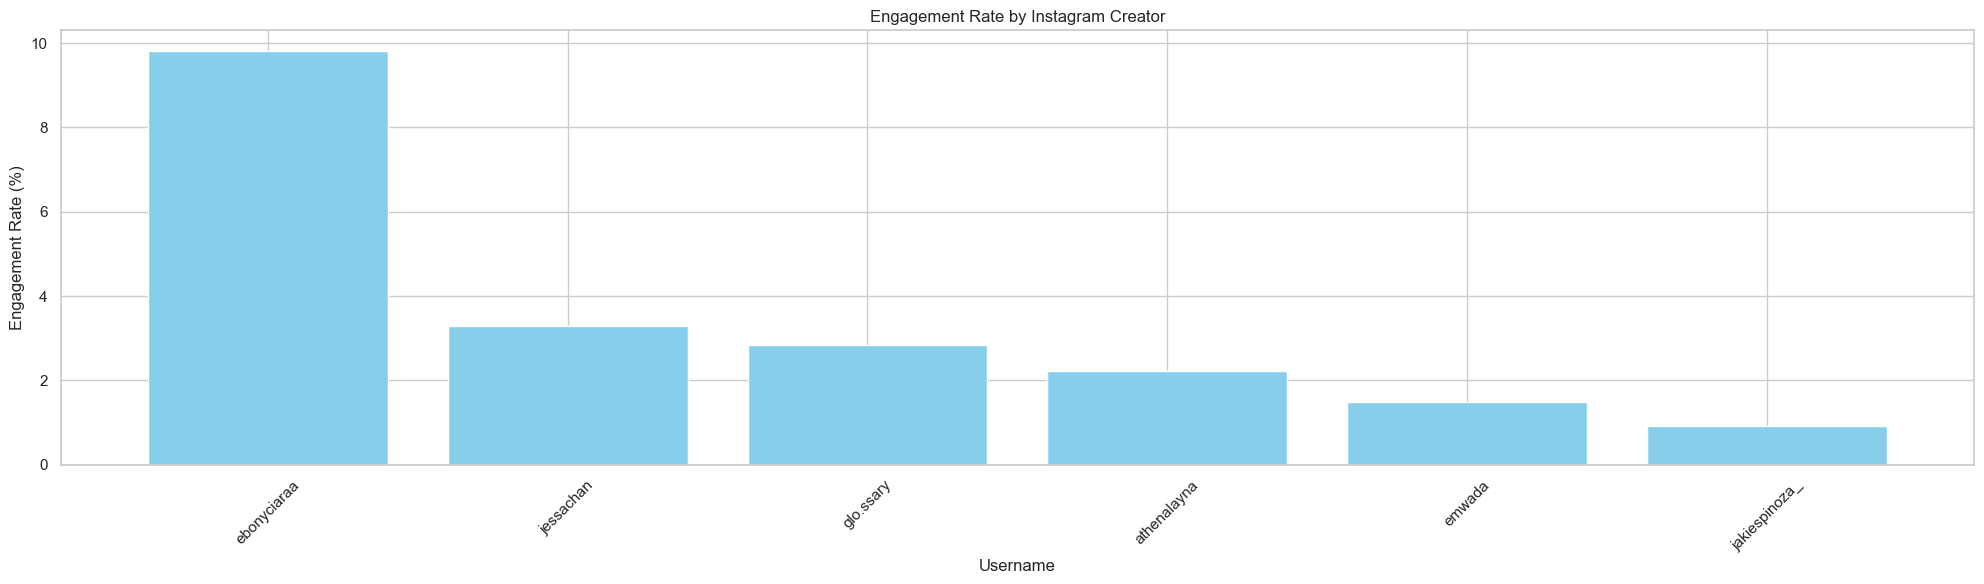

In [232]:
##this should be the only thing that one changes. Change the creators/brand for a different analysis on brand
belif_creators =  ['ebonyciaraa', 'athenalayna', 'jessachan', 'jakiespinoza_', 'glo.ssary',  'emwada', 
                         'chynnarowe']
belif = total_analysis(belif_creators)